In [1]:
from sirpy.models.SIR import SIR
import pandas as pd
from LeastSquaresTrainer import LeastSquaresTrainer
import numpy as np
from abstractModel import EmptyModel
from abstractModel import State, Transition
from sirpy.metrics.MetricsFuns import RMSE, MAE, MSE

# Using a premade model and training it with least squares

In [2]:
data = pd.read_csv("covid_japan_processed.csv", parse_dates=[0], index_col=0)
data = data.iloc[:-1] # Dropping the last row because it is weird data point messing with the fitting
t = (data.index - data.index.min()) / (data.index.max() - data.index.min())
data["t"] = t
train = data.iloc[0:100,:]
test = data.iloc[100::,:]
print(f"Train is the first {len(train)} days and test is remaining {len(test)} days.") #Typo

Train is the first 100 days and test is remaining 22 days.


In [3]:
# Describir los atributos
easy_sir = SIR(
  name="My sir",
  hyper_params={
    "time_space": (0, train.t.max()),
    "time_range": t.to_numpy()[0:len(train)],
    "test_time_space": (train.t.max(), test.t.max()),
    "test_time_range": t.to_numpy()[len(train):len(train) + len(test)],
  },
  train_params={
    "beta": 0.5,
    "gamma": 0.2,
  },
  static_params={
      "initial_condition": np.array([0.75, 0.01, 0.24]),
  }
)
easy_sir.train_data = train.iloc[:,0:3].to_numpy()
easy_sir.test_data = test.iloc[:,0:3].to_numpy()
easy_sir

Model: My sir
States: ['S', 'I', 'R']
Transitions: ['$\\beta SI$', '$\\gamma I$']
Has train data? True
Has test data? True
Trained? False

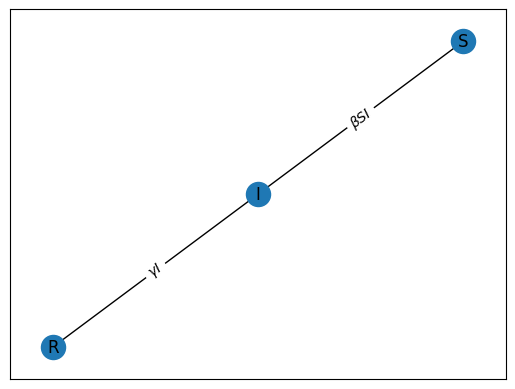

In [4]:
easy_sir.plot_model()

In [5]:
trainer = LeastSquaresTrainer(easy_sir)
trainer.train()

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-1.981e-02  1.249e-01 ... -4.031e-02  8.209e-02]
           x: [ 9.174e+00  5.103e-01]
        cost: 0.7256396424305659
         jac: [[ 0.000e+00  0.000e+00]
               [ 0.000e+00  0.000e+00]
               ...
               [-7.251e-02  2.260e-01]
               [-1.586e-02 -1.081e-01]]
        grad: [-2.151e-07  2.750e-06]
  optimality: 2.7497194809954217e-06
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 10
        njev: 10

In [6]:
trainer.metrics = {
  "MAE": MAE,
  "MSE": MSE,
  "RMSE": RMSE,
}

<AxesSubplot: >

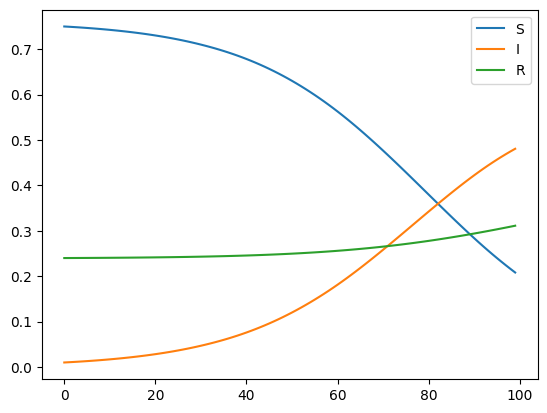

In [7]:
trainer.plot_curves()

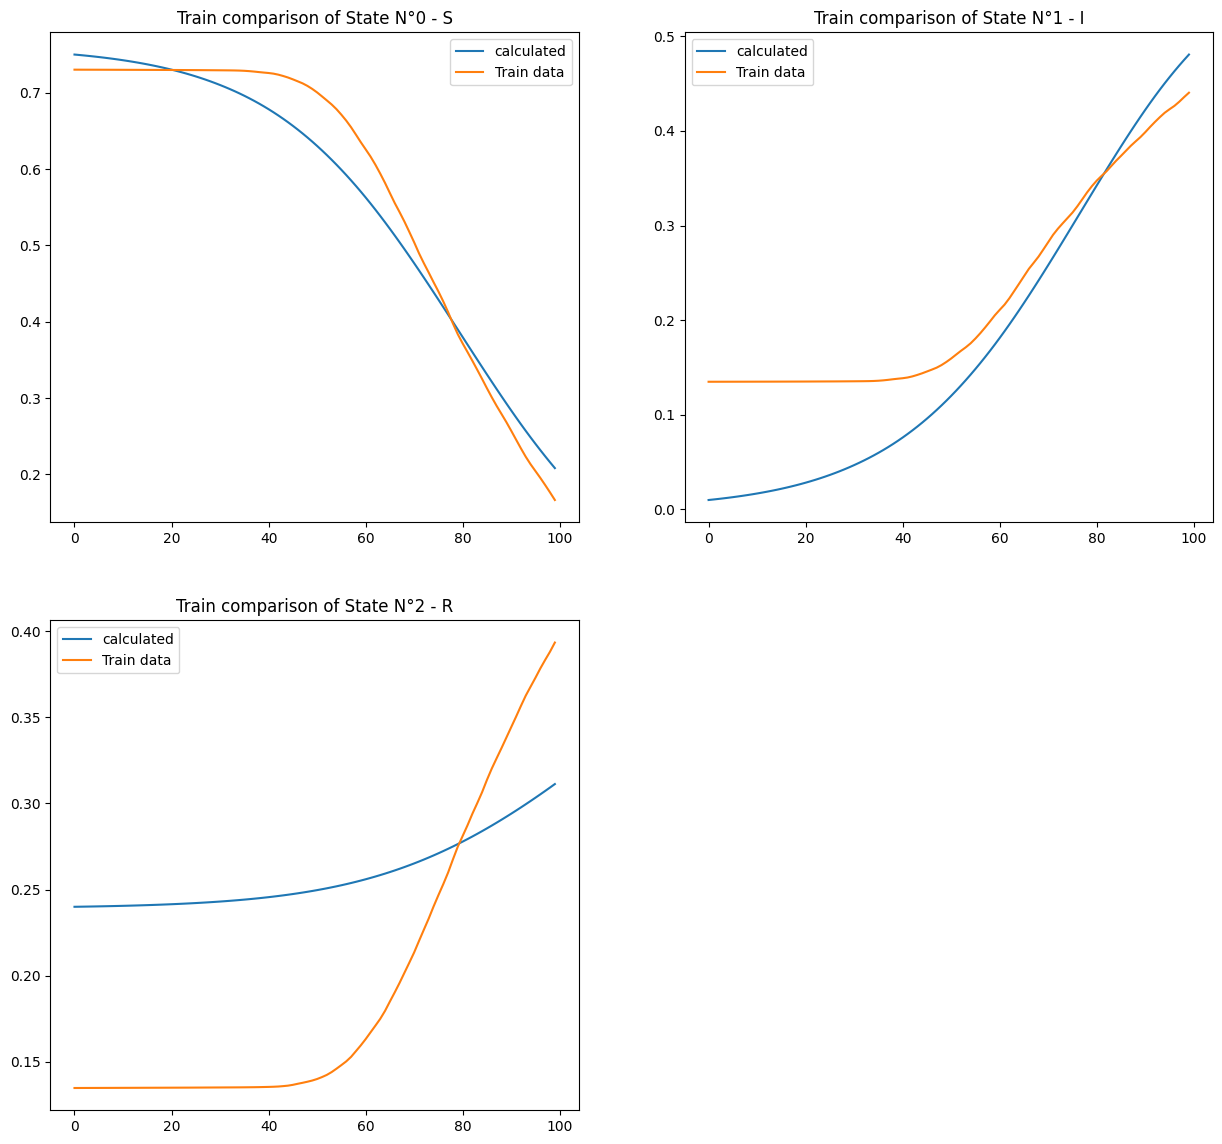

In [8]:
trainer.plot_train_curves()

In [9]:
print(trainer.get_metrics_report())

Metric report: 
	MAE: 0.07166894434297753. 
	MSE: 0.005930079503492166. 
	RMSE: 0.07700700944389521. 



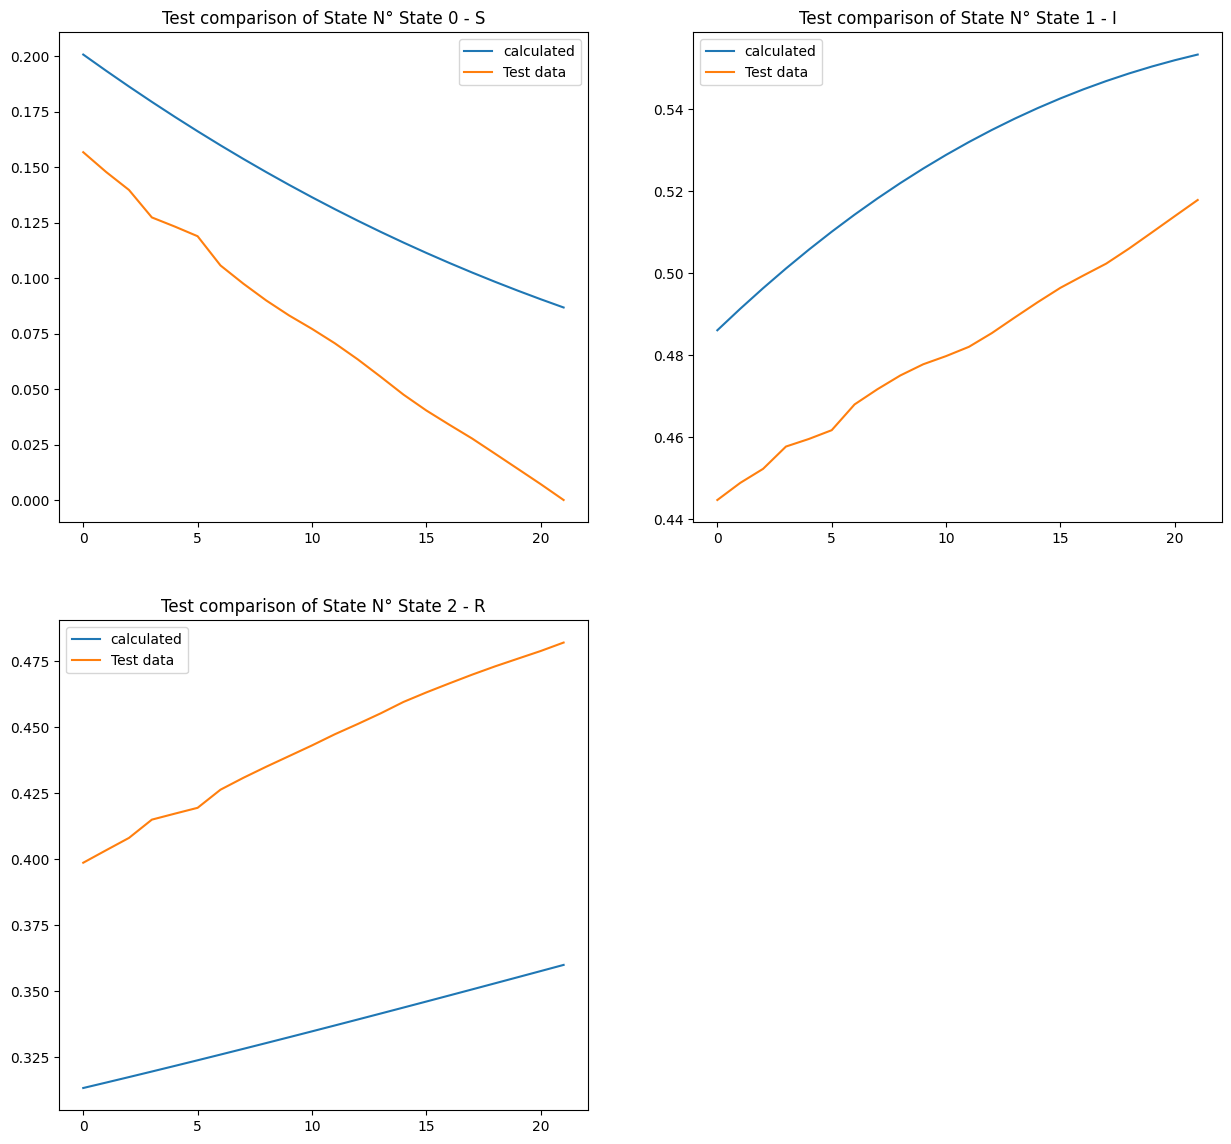

In [10]:
trainer.plot_test_curves()

# Crafting a model: SIRS Model


In [11]:
m = EmptyModel(
  name = "Quickmade SIRS Model",
  hyper_params={
    "time_space": (0, train.t.max()),
    "time_range": t.to_numpy()[0:len(train)],
    "test_time_space": (train.t.max(), test.t.max()),
    "test_time_range": t.to_numpy()[len(train):len(train) + len(test)]
  },
  train_params={
    "beta": 0.5,
    "beta2": 0.25,
    "gamma": 0.3,
    "alpha": 0.3,
    "initial_condition": [0.74, 0.01, 0.24],
  },
  static_params={
  }
)

m.add_state(State("S"))
m.add_state(State("I"))
m.add_state(State("R"))

m.add_transition(Transition(
  "S->I",
  "S",
  "I",
  lambda t, y, p: p.beta * y.S * y.I + p.beta2 * y.S * y.I ** 2
))

m.add_transition(Transition(
  "I->R",
  "I",
  "R",
  lambda t, y, p: p.gamma * y.I
))

m.add_transition(Transition(
  "R->S",
  "R",
  "S",
  lambda t, y, p: p.alpha * y.R
))


m.train_data = train.iloc[:,0:3].to_numpy()
m.test_data = test.iloc[:,0:3].to_numpy()
another_trainer = LeastSquaresTrainer(m)
m

Model: Quickmade SIRS Model
States: ['S', 'I', 'R']
Transitions: ['S->I', 'I->R', 'R->S']
Has train data? True
Has test data? True
Trained? False

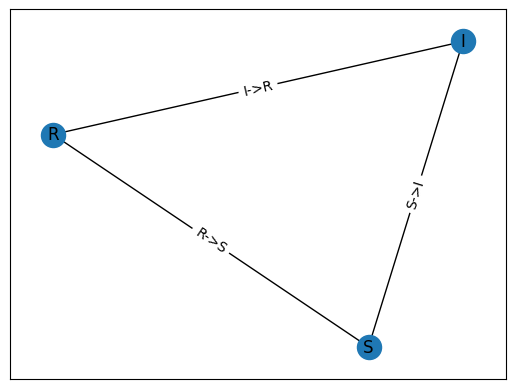

In [12]:
m.plot_model()

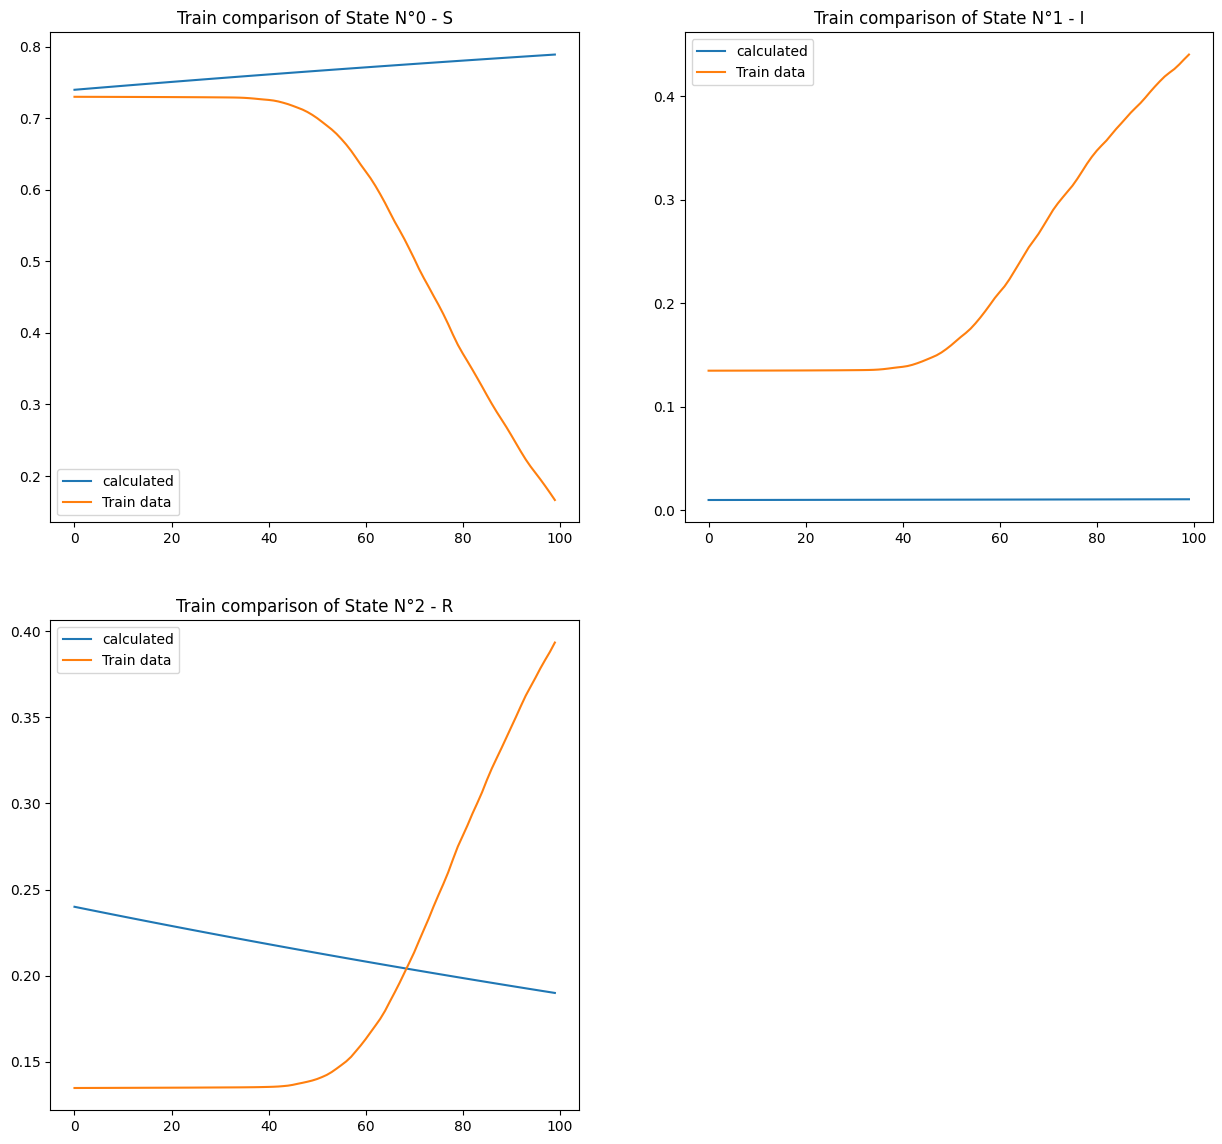

In [13]:
another_trainer.plot_train_curves()

In [14]:
#TODO: Graficos de residuos (Scatter plot)
def another_residual_fun(x, trainer_):
    """
    This is an example of another residual function that only uses the infected data
    to adjust the parameters.
    """
    trainer_.model.set_train_params_from_list(x)
    # take the same amount of columns of the train data
    y_pred = trainer_.calculate_curves()[:, 0:trainer_.model.train_data.shape[1]]
    diff = trainer_.model.train_data - y_pred
    return diff.flatten()
another_trainer.residual_fun = another_residual_fun

In [15]:
%%time
another_trainer.train()

CPU times: user 633 ms, sys: 4.61 ms, total: 637 ms
Wall time: 646 ms


     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-4.162e-02 -1.487e-03 ... -6.482e-02  8.251e-03]
           x: [-5.914e+00  1.543e+01 -3.310e+00 -5.868e+00  7.718e-01
                1.364e-01  8.948e-02]
        cost: 0.10631969729489113
         jac: [[-0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               [-0.000e+00  0.000e+00 ... -1.000e+00  0.000e+00]
               ...
               [-5.857e-01 -1.034e-01 ... -6.984e+00 -1.483e+01]
               [ 2.123e+00  3.241e-01 ...  9.666e+01 -9.157e+01]]
        grad: [-1.352e-05 -1.886e-06  4.857e-05 -2.301e-05  5.342e-05
               -9.373e-04  1.172e-03]
  optimality: 0.0011716990132686345
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                0.000e+00  0.000e+00]
        nfev: 29
        njev: 22

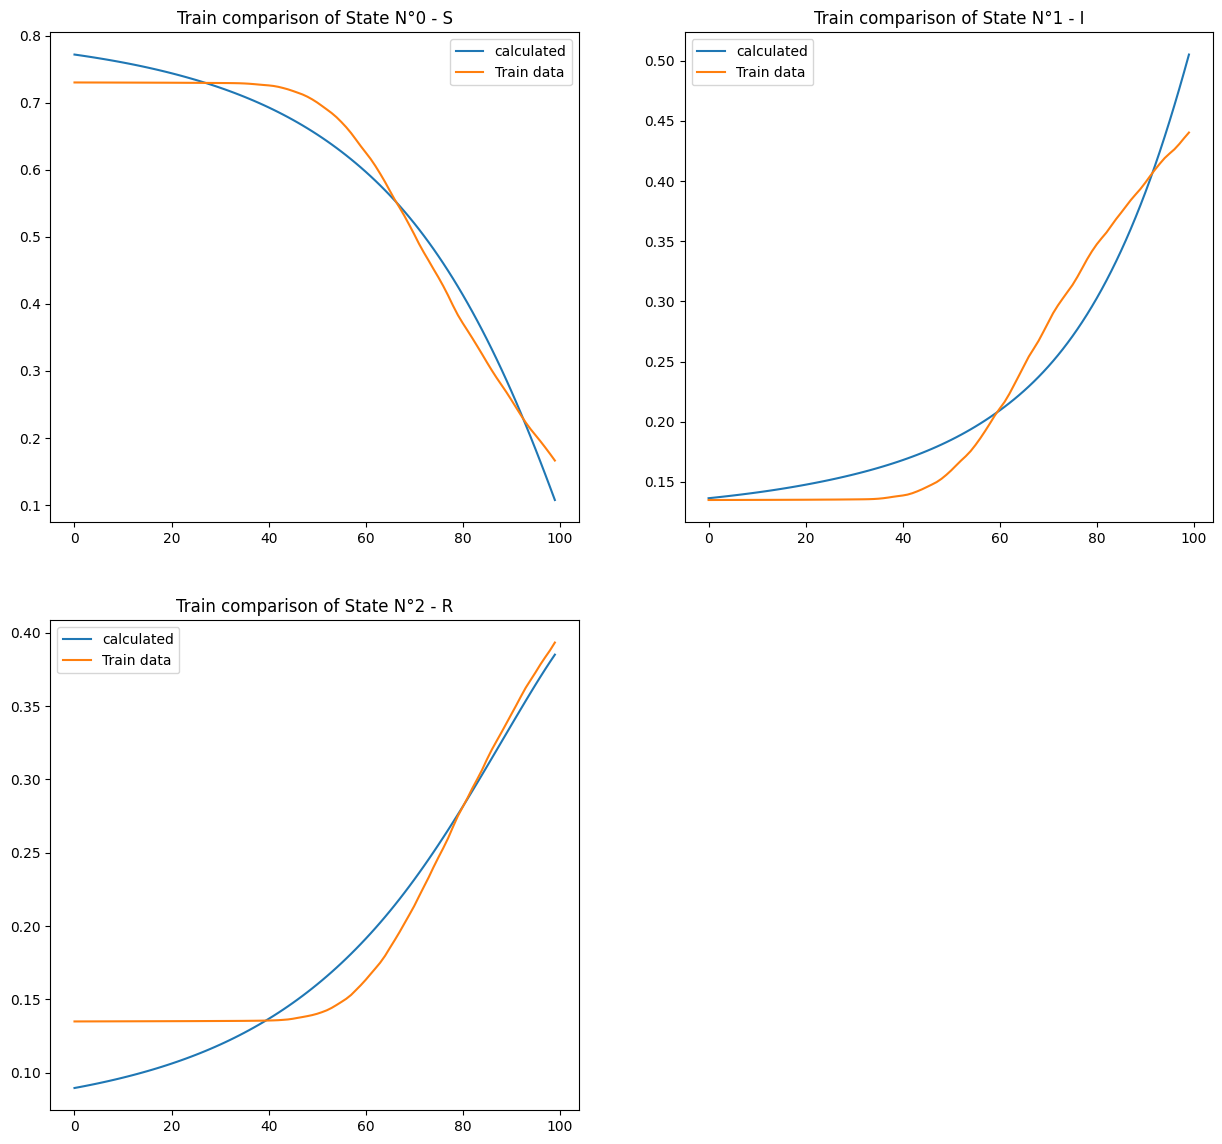

In [16]:
another_trainer.plot_train_curves()

In [17]:
another_trainer.metrics = {
  "MAE": MAE,
  "MSE": MSE,
  "RMSE": RMSE,
}

In [18]:
print(trainer.get_metrics_report())

Metric report: 
	MAE: 0.07166894434297753. 
	MSE: 0.005930079503492166. 
	RMSE: 0.07700700944389521. 



In [19]:
print(another_trainer.get_metrics_report())

Metric report: 
	MAE: 0.13462172380057555. 
	MSE: 0.027352666293185533. 
	RMSE: 0.16538641508051843. 



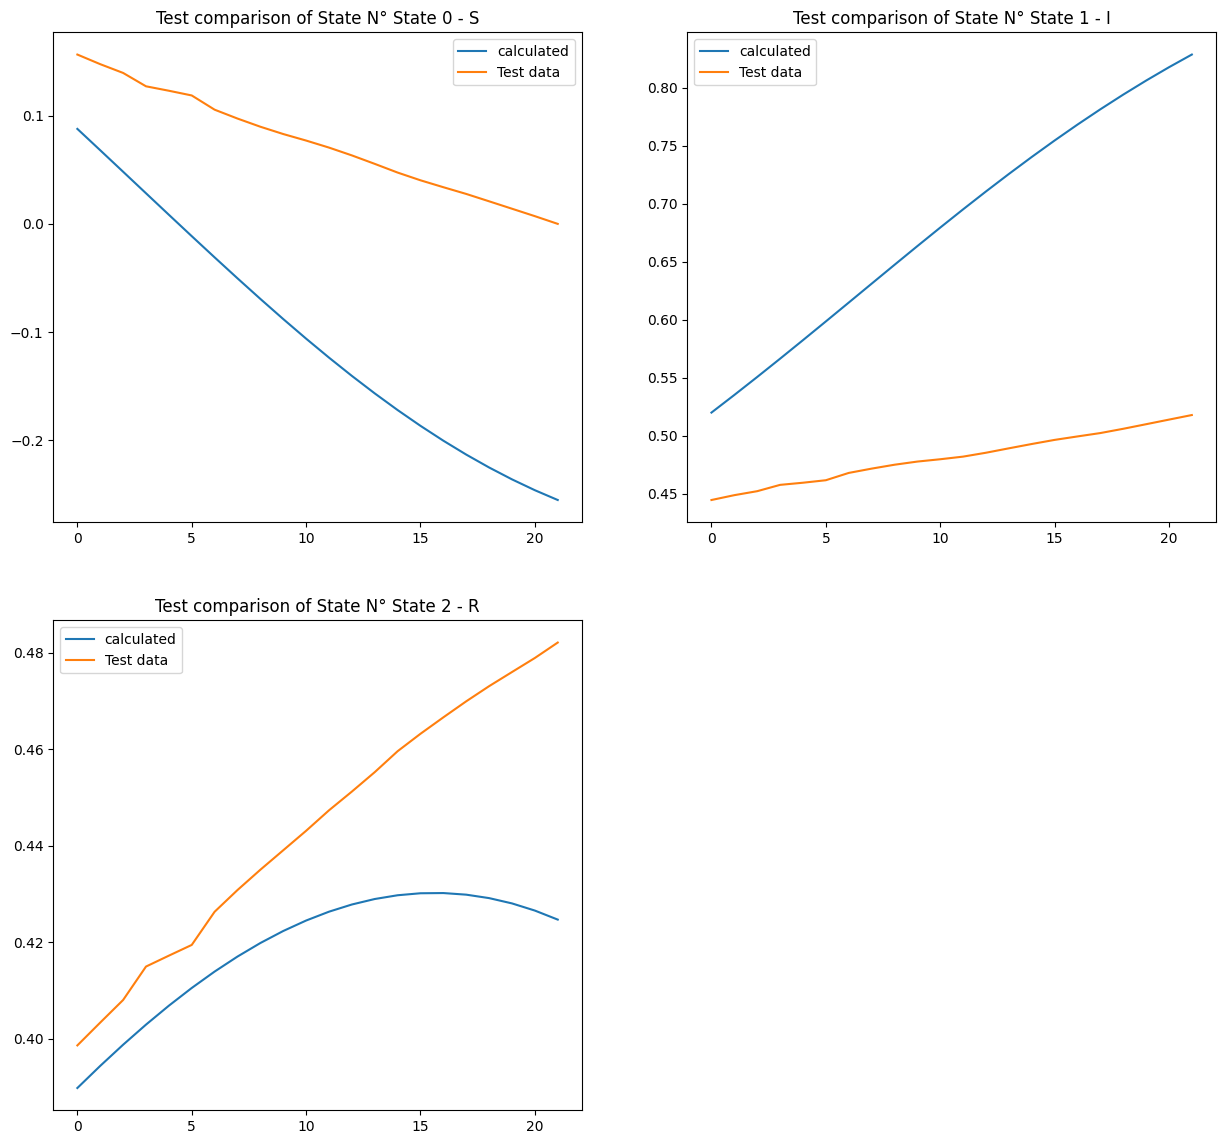

In [20]:
another_trainer.plot_test_curves()